```python
  -- Hardware Info --
  Model Name:	MacBook Pro
  Model Identifier:	MacBookPro11,2
  Processor Name:	Intel Core i7
  Processor Speed:	2.2 GHz
  Number of Processors:	1
  Total Number of Cores:	4
  L2 Cache (per Core):	256 KB
  L3 Cache:	6 MB
  Memory:	16 GB
```

In [2]:
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.optimizers import SGD
import cv2, numpy as np
import matplotlib.pyplot as plt
import pickle
import IPython
import time
import urllib2
from IPython.display import SVG

# plot inline
%matplotlib inline

## VGG-16 model

In [3]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

## Utility functions

In [4]:
# unpickle dictionary to convert ids to human readable labels
imagenet1000_clsid_to_human = pickle.load(urllib2.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )
#pickle.load( open( "imagenet1000_clsid_to_human.pkl", "rb" ) )

# pre-process image to feed to the VGG-16 network, zero-center data by subtacting mean across each channel
def img_preprocess(img):
    im_ = cv2.resize(img, (224, 224)).astype(np.float32)
    im_[:,:,0] -= 103.939
    im_[:,:,1] -= 116.779
    im_[:,:,2] -= 123.68
    im_ = im_.transpose((2,0,1))
    im_ = np.expand_dims(im_, axis=0)
    return im_

# function to get top k probability class ids 
def get_topk(predictions, k=5):
    return (-predictions.squeeze()).argsort()[:k] 

## VGG-16 model with pre-trained weights

In [5]:
start = time.time()
model = VGG_16('vgg16_weights.h5')
end = time.time()
print "VGG-16 weights load from disk: %fs" % (end - start)

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

start = time.time()
model.compile(optimizer=sgd, loss='categorical_crossentropy')
end = time.time()
print "theano graph compile: %fs" % (end - start)

VGG-16 weights load from disk: 4.430257s


/Users/yrevar/virtualenvs/keras/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


theano graph compile: 16.600856s


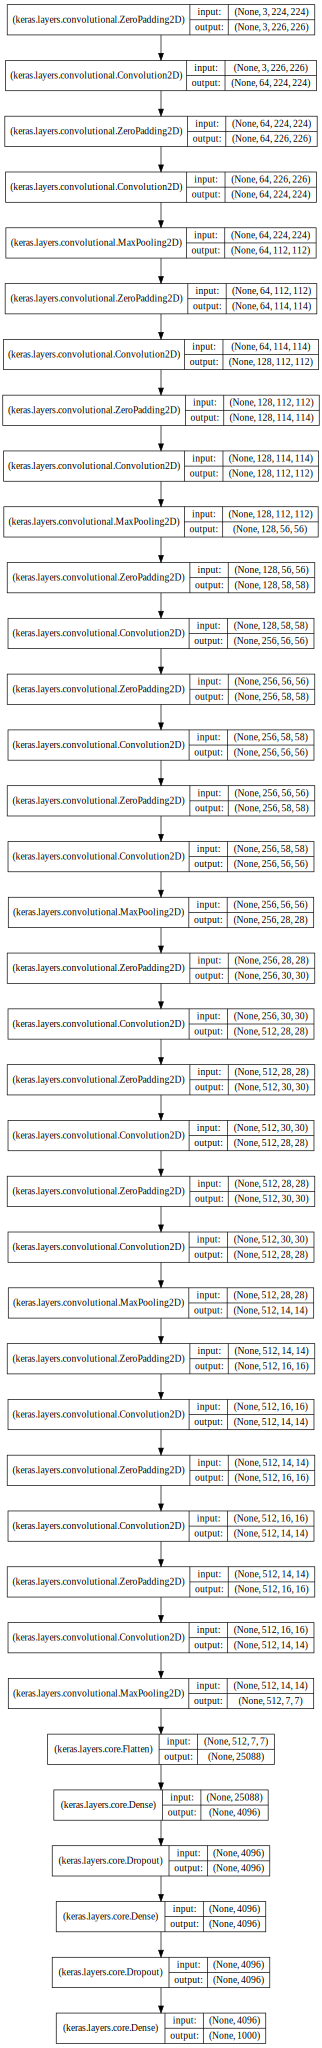

In [6]:
# Visualize model

# alternate method
# plot(model, to_file='model.png', show_shape=True)
# IPython.display.Image('./model.png', width=400)

SVG(to_graph(model, show_shape=True).create(prog='dot', format='svg'))

## Hello NNet: classify customary input cat

<img src="./cat.jpg"> cat.jpg <img>

In [10]:
start = time.time()
predictions = model.predict(img_preprocess(cv2.imread('cat.jpg')))
end = time.time()
print "VGG-16 forward pass: %fs" % (end - start)
topk_ = [imagenet1000_clsid_to_human[i] for i in get_topk(predictions, 5)]

VGG-16 forward pass: 7.185248s


In [11]:
print topk_

['kit fox, Vulpes macrotis', 'red fox, Vulpes vulpes', 'Egyptian cat', 'tiger cat', 'tabby, tabby cat']


## Hello NNet: classify image from live camera feed

In [12]:
cap = cv2.VideoCapture(0)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Display the resulting frame
    cv2.imshow('frame', frame)
    keypress_ = cv2.waitKey(1)
    if keypress_ & 0xFF == ord('c'): # press c to capture image for classifcation
        capture_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        break
    elif keypress_ & 0xFF == ord('q'):
        break
        
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

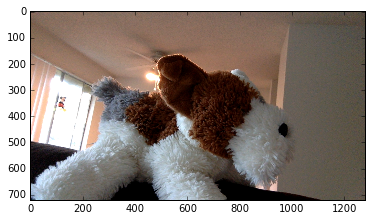

In [14]:
plt.imshow(capture_frame)

In [16]:
predictions = model.predict(img_preprocess(capture_frame))
print [imagenet1000_clsid_to_human[i] for i in get_topk(predictions, 5)]

['wire-haired fox terrier', 'standard poodle', 'teddy, teddy bear', 'Bedlington terrier', 'toy poodle']


## Transfer Learning

In [7]:
def VGG_16_FullyConv(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, 7, 7, activation='relu'))
    model.add(Convolution2D(1024, 1, 1, activation='relu')) 
    model.add(Convolution2D(1000, 1, 1)) 
    model.add(Flatten())
    model.add(Activation('softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [8]:
model_fullyconv = VGG_16_FullyConv()

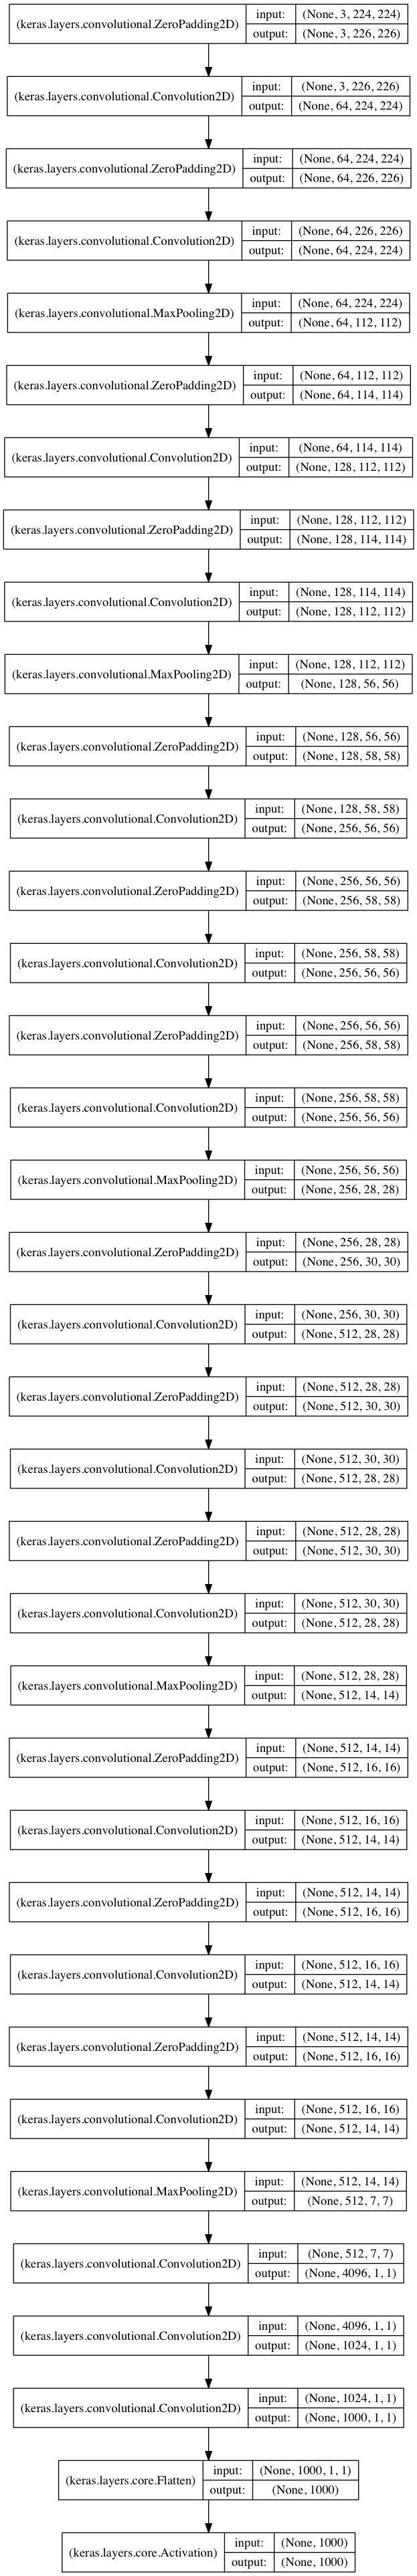

In [44]:
graph = to_graph(model_fullyconv, show_shape=True)
graph.write_png("model.png")
IPython.display.Image("model.png", width=400)

In [128]:
for i in range(len(model.layers)-6):
    if len(model.layers[i].get_weights()):
        model_fullyconv.layers[i].W.set_value(model.layers[i].get_weights()[0])
        model_fullyconv.layers[i].b.set_value(model.layers[i].get_weights()[1])
        model_fullyconv.layers[i].trainable = False

In [129]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model_fullyconv.compile(optimizer=sgd, loss='categorical_crossentropy')

## Multi-label classification

In [91]:
def VGG_16_multilabel(weights_path=None):
    m = Graph()
    
    m.add_input(name='input', input_shape=(3,224,224))
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="maxp13")
    
    m.add_node(Dense(2048, activation='relu'), name="h1fc1", input="fork")
    m.add_node(Dropout(0.5), name="h1fc1_drop", input="h1fc1")
    m.add_node(Dense(1024, activation='relu'), name="h1fc2", input="h1fc1_drop")
    m.add_node(Dropout(0.5), name="h1fc2_drop", input="h1fc2")
    m.add_node(Dense(9, activation='softmax'), name="h1out", input="h1fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h2fc1", input="fork")
    m.add_node(Dropout(0.5), name="h2fc1_drop", input="h2fc1")
    m.add_node(Dense(1024, activation='relu'), name="h2fc2", input="h2fc1_drop")
    m.add_node(Dropout(0.5), name="h2fc2_drop", input="h2fc2")
    m.add_node(Dense(9, activation='softmax'), name="h2out", input="h2fc2_drop")
    
    m.add_output(name='output1', input='h1out')
    m.add_output(name='output2', input='h2out')

    if weights_path:
        m.load_weights(weights_path)

    return m

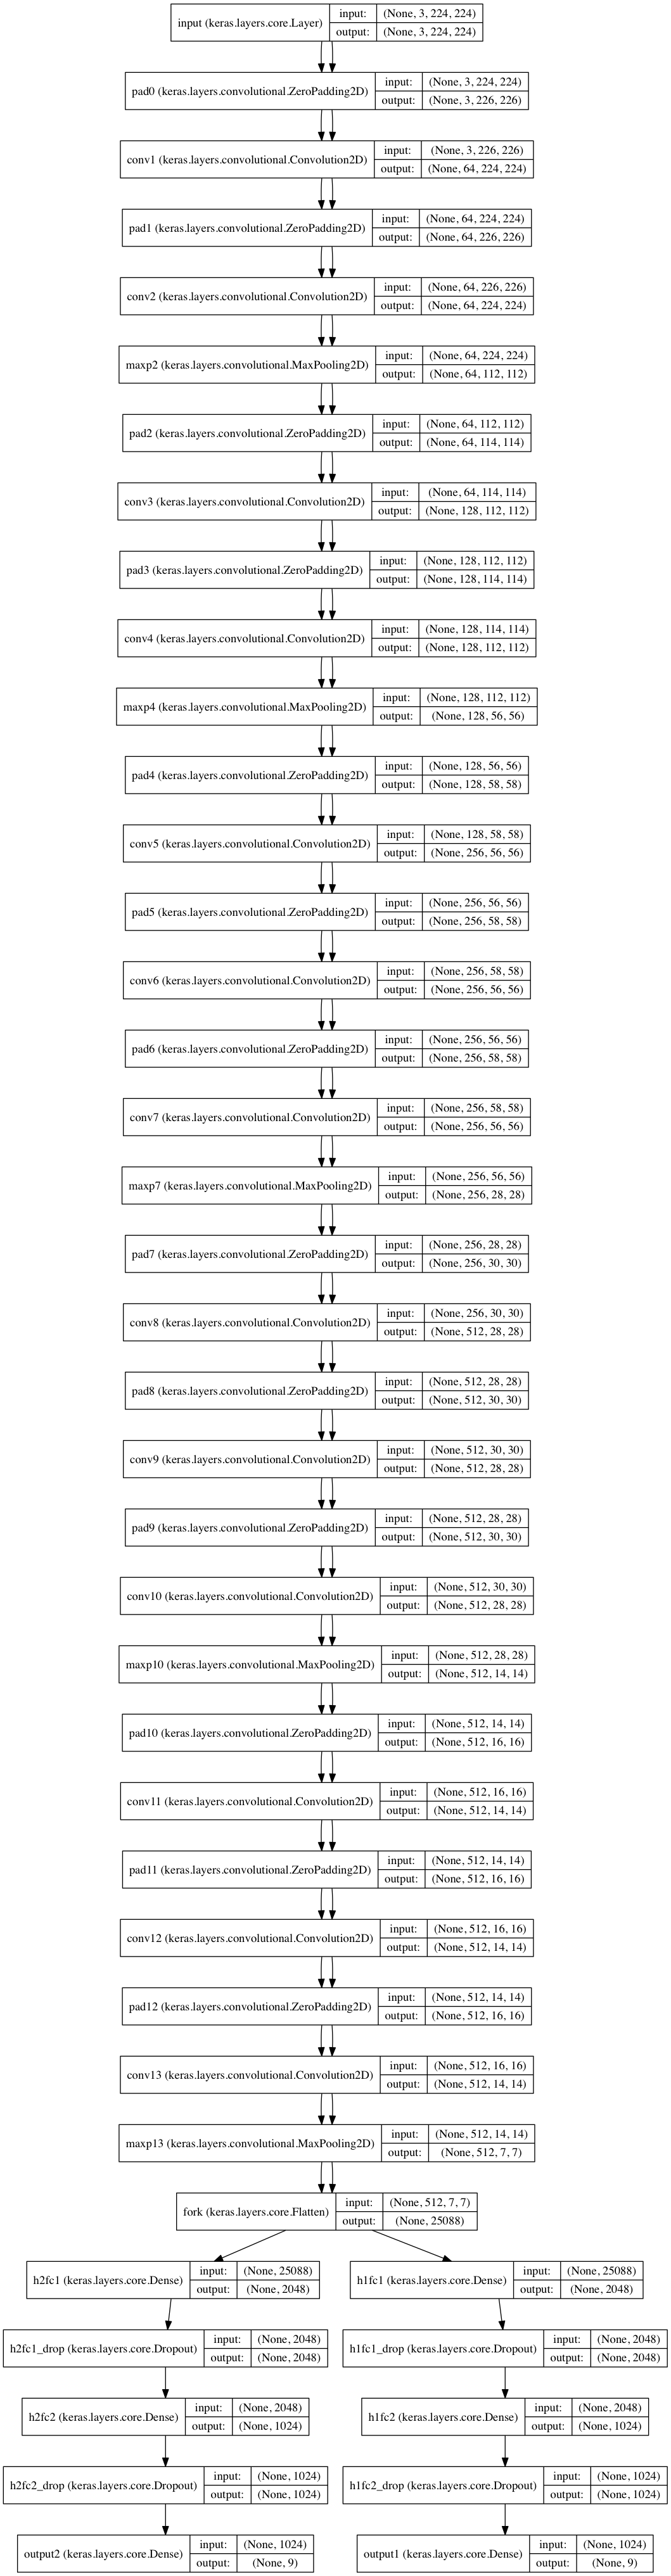

In [92]:
yelp_simplified_model = VGG_16_multilabel()
plot(yelp_simplified_model, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png', width=400)